# Data Preparation

## Data Downloading (social-chemistry-101 dataset)

In [ ]:
import os
import wget
import zipfile

"""
Download the social-chemistry-101 zip file and unzip it
"""
url = "https://storage.googleapis.com/ai2-mosaic-public/projects/social-chemistry/data/social-chem-101.zip"
data_dir = os.getcwd()+"/data/"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
wget.download(url, data_dir)

with zipfile.ZipFile(data_dir+'/social-chem-101.zip', 'r') as zip_ref:
    zip_ref.extractall(data_dir)

## Reading & filtering data

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter

In [88]:
df = pd.read_csv(os.getcwd()+'/data/social-chem-101/social-chem-101.v1.0.tsv', sep='\t')

df_AITA = df[df['area']=='amitheasshole']
df_AITA = df_AITA[['split', 'situation', 'rot', 'situation-short-id', 'rot-moral-foundations', 'rot-judgment', 'rot-id']]

df_AITA.dropna(inplace=True)

In [91]:
# Review social-chemistry-101 data stats

def return_rotCnt_stat(df):
    situationID_rotCnt = Counter()
    situationID_rotCnt.update(df['situation-short-id'].tolist())

    rotCnt_IDs = {}
    for key, cnt in situationID_rotCnt.items():
        if cnt not in rotCnt_IDs:
            rotCnt_IDs[cnt] = [key]
        else:
            rotCnt_IDs[cnt].append(key)

    rotCnt_stat = {}
    for cnt in rotCnt_IDs:
        rotCnt_stat[cnt] = len(list(set(rotCnt_IDs[cnt])))

    return rotCnt_stat

print('# rules of thumb per situation:',return_rotCnt_stat(df_AITA))

# rules of thumb per situation: {1: 5502, 3: 6672, 4: 2599, 2: 12801, 5: 1193}


## Expand the number of rule of thumb for situations


### Strategy
- Change judgments for the same action (1 RoT -> expand it to 5 RoTs)
- Remove redundant items (similar judgments for same actions)
- Keep K (=5) items

In [92]:
judgment_group = {
    "shouldn't": ['should not', "shouldn't"],
    'should': ['should', "should"],
    'okay': ['okay', 'ok', 'fine', 'normal', 'acceptable', 'understandable', 'allowed'],
    'not-okay': ['not okay','not ok', 'not fine', 'not normal', 'not acceptable', 'not undedrstandable', 'not allowed'],
    'nice': ['nice', 'kind', 'polite', 'considerate', 'good'],
    'rude': ['hurtful', 'mean', 'rude', 'inconsiderate', 'bad'],
    'right': ['right', 'expected', 'reasonable', 'appropriate'],
    'wrong': ['wrong', 'not expected', 'unreasonable', 'inappropriate']
}
mapping_rules = {
    'should':["shouldn't", 'okay', 'not-okay', 'nice', 'rude'],
    "shouldn't": ['should', 'okay', 'not-okay', 'nice', 'rude'],
    'okay':['not-okay', 'nice', 'rude', 'right', 'wrong'],
    'not-okay': ['okay', 'nice', 'rude', 'right', 'wrong'],
    'nice': ['rude', 'okay', 'not-okay', 'right', 'wrong'],
    'rude': ['nice', 'okay', 'not-okay', 'right', 'wrong'],
    'right': ['wrong', 'okay', 'not-okay', 'nice', 'rude'],
    'wrong': ['right', 'okay', 'not-okay', 'nice', 'rude'],
}

In [93]:
def generate_RoT(_judgment, _rot):
    # identify key judgment words
    _judgment_word, _judgment_group_key = '', ''
    word_list = _judgment.split()
    
    for key in judgment_group:    
        for word in word_list:
            if word.lower() == 'should' and word_list.index(word) < len(word_list)-1 and \
                                    word_list[word_list.index(word)+1].lower() == 'not':
                _judgment_group_key, _judgment_word = "shouldn't", 'should not'
                break
            else:
                if word.lower() in judgment_group[key]:
                    _judgment_group_key, _judgment_word = key, word.lower()
                    break
        
        if _judgment_word != '':
            break

    if _judgment_word == '':
        return [], []
    
    mapping_keys = mapping_rules[_judgment_group_key]
    generated_rots, generated_judgments = [], []
    for mapping_idx, elem in enumerate(mapping_keys):
        random_idx = np.random.randint(len(judgment_group[elem]), size=1)[0]
        generated_rots.append(_rot.lower().replace(_judgment_word, judgment_group[elem][random_idx]))
        generated_judgments.append(_judgment.lower().replace(_judgment_word, judgment_group[elem][random_idx]))
        
    return generated_rots, generated_judgments

In [94]:
# Generate RoTs

additional_row_series = []
for idx, row in df_AITA.iterrows():
    generated_rots, generated_judgments = generate_RoT(row['rot-judgment'], row['rot'])
    for _new_rot, _new_judgment in zip(generated_rots, generated_judgments):
        copy_row = row.copy()
        copy_row['rot'] = _new_rot
        copy_row['rot-judgment'] = _new_judgment
        additional_row_series.append(copy_row)


df_additional = pd.DataFrame(additional_row_series)

df_all = pd.concat([df_AITA, df_additional])

generated = [0 for elem in range(len(df_AITA))]
generated += [1 for elem in range(len(df_additional))]

df_all['generated'] = generated
df_all.sort_values(by=['split', 'situation-short-id'], ignore_index=True, inplace=True)

In [141]:
# Remove duplicated RoTs

duplicated_indices = []
for _id in tqdm(list(set(df_all['situation-short-id'].tolist()))):
    _df = df_all[df_all['situation-short-id'].isin([_id])]
    duplicated_indices += _df[_df.duplicated(subset=['rot'])].index.tolist()

df_all.drop(duplicated_indices, inplace=True)

100%|██████████| 28767/28767 [04:45<00:00, 100.91it/s]


In [144]:
df_all.to_csv(os.getcwd()+'/data/social-chem-101/RoT-augmented.tsv', sep='\t', index=False)

### Keep K rules-of-thumb per situation

- Remove situations where their total # of rules-of-thumb is less than K
- If RoTs are not generated, keep all of them
- Per situation, get the number of RoT that we should fill in
- Compute vector representation of non-generated RoTs
- Get the 'farthest distance' items among generated RoTs (so that we get diverse RoTs per situation)

In [97]:
k = 5

In [145]:
# remove situation ids that have less than 5 counts

situationID_rotCnt = Counter()
situationID_rotCnt.update(df_all['situation-short-id'].tolist())

situationIDs_to_remove = [key for key, value in situationID_rotCnt.items() if value < 5]
df_all = df_all[~df_all['situation-short-id'].isin(situationIDs_to_remove)]

print('Removed %d situations that have less than %d rules-of-thumb'%(len(situationIDs_to_remove), k))

Removed 1315 situations that have less than 5 rules-of-thumb


In [146]:
# Approach 1. Random selection

np.random.seed(624)

random_items_indices = []
for _id in tqdm(situationID_rotCnt.keys()):
    _df = df_all[df_all['situation-short-id'].isin([_id])]
    _curr_appended_indices = []
    
    if len(_df) == 0:
        continue
    
    # 0. when # rules-of-thumb is already K
    if len(_df) == 5:
        _curr_appended_indices += _df.index.tolist()
    
    else:
        # 1. include annotated ROTs
        _curr_appended_indices += _df[_df['generated']==0].index.tolist()

        # 2. Random selection
        RoT_candidate_indices = _df[~_df.index.isin(_curr_appended_indices)].index.tolist()
        remaining_items = k - len(_curr_appended_indices)
        _curr_appended_indices += list(np.random.choice(RoT_candidate_indices, size=remaining_items, replace=False))

    random_items_indices += _curr_appended_indices

df_topk_random = df_all[df_all.index.isin(random_items_indices)]
df_topk_random.sort_values(by=['split', 'situation-short-id'], inplace=True, ignore_index=True)
df_topk_random.to_csv(os.getcwd()+'/../data/social-chem-101/RoT-augmented-topK-random.tsv', sep='\t', index=False)

100%|██████████| 28767/28767 [04:30<00:00, 106.19it/s]


In [154]:
# Approach 2. Balanced selection

np.random.seed(624)

balanced_items_indices = []
for _id in tqdm(situationID_rotCnt.keys()):
    _df = df_all[df_all['situation-short-id'].isin([_id])]
    _curr_appended_indices = []
    
    if len(_df) == 0:
        continue
    
    # 0. when # rules-of-thumb is already K
    if len(_df) == 5:
        _curr_appended_indices += _df.index.tolist()
        balanced_items_indices += _curr_appended_indices
        continue

    # 1. include annotated ROTs
    _curr_appended_indices += _df[_df['generated']==0].index.tolist()
    if len(_curr_appended_indices) == k:
        balanced_items_indices += _curr_appended_indices
        continue
        
    remaining_items = k - len(_curr_appended_indices)
    _df_candidate = _df[~_df.index.isin(_curr_appended_indices)]
    remaining_RoT_IDs = list(set(_df_candidate['rot-id'].tolist()))
        
    if len(remaining_RoT_IDs) >= remaining_items:
        _over_appended_indices = []
        for _remaining_id in remaining_RoT_IDs:
            _df_remaining = _df_candidate[_df_candidate['rot-id'].isin([_remaining_id])]
            _df_remaining_indices = _df_remaining.index.tolist()
            _over_appended_indices += list(np.random.choice(_df_remaining_indices, size=1))
        _curr_appended_indices += list(np.random.choice(_over_appended_indices, size=remaining_items, replace=False))
    else:
        _under_appended_indices = []
        for _remaining_id in remaining_RoT_IDs:
            _df_remaining = _df_candidate[_df_candidate['rot-id'].isin([_remaining_id])]
            _df_remaining_indices = _df_remaining.index.tolist()
            _under_appended_indices += list(np.random.choice(_df_remaining_indices, size=1))
        
        _rest_indices = [elem for elem in _df_candidate.index.tolist() if elem not in _under_appended_indices]
        _under_appended_indices += list(np.random.choice(_rest_indices, size=remaining_items - len(_under_appended_indices), replace=False))
        _curr_appended_indices += _under_appended_indices
        
    balanced_items_indices += _curr_appended_indices
    
    
df_topk_balanced = df_all[df_all.index.isin(balanced_items_indices)]
df_topk_balanced.sort_values(by=['split', 'situation-short-id'], inplace=True, ignore_index=True)
df_topk_balanced.to_csv(os.getcwd()+'/data/social-chem-101/RoT-augmented-topK-balanced.tsv', sep='\t', index=False)

100%|██████████| 28767/28767 [04:47<00:00, 100.23it/s]


In [ ]:
# # Approach 3. Distance-based selection
# """
# distance-based selection tends to prefer one RoT (distances are not diverse)
# however, we want to include generated RoTs as diverse as possible
# -> discard the method
# """

# from sentence_transformers import SentenceTransformer
# from sklearn import metrics

# """
# # Run this in the gpu-enabled machine

# smodel = SentenceTransformer('all-MiniLM-L12-v2')

# all_RoTs = df_all['rot'].tolist()
# all_RoT_embeddings = smodel.encode(all_RoTs)
# """

# all_RoT_embeddings = np.load(open(os.getcwd()+'/data/social-chem-101/RoT_embeddings.npy', 'rb'))

# dfIndex_to_npyIdx = {}
# for idx, elem in enumerate(df_all.index.tolist()):
#     dfIndex_to_npyIdx[elem] = idx
    
# distance_items_indices = []
# for _id in tqdm(situationID_rotCnt.keys()):
#     _df = df_all[df_all['situation-short-id'].isin([_id])]
#     _curr_appended_indices = []
    
#     if len(_df) == 0:
#         continue
        
#     # 0. when # rules-of-thumb is already K
#     if len(_df) == 5:
#         _curr_appended_indices += _df.index.tolist()
#         distance_items_indices += _curr_appended_indices
    
#     _curr_appended_indices += _df[_df['generated']==0].index.tolist()
#     if len(_curr_appended_indices) == k:
#         distance_items_indices += _curr_appended_indices
#         continue


#     # 2. Random selection
#     remaining_items = k - len(_curr_appended_indices)

#     annot_indices = [dfIndex_to_npyIdx[elem] for elem in _df[_df['generated']==0].index.tolist()]
#     annot_embeddings = all_RoT_embeddings[annot_indices]

#     RoT_candidate_indices = _df[~_df.index.isin(_curr_appended_indices)].index.tolist()
#     RoT_candidate_embIdx = [dfIndex_to_npyIdx[elem] for elem in RoT_candidate_indices]
#     RoT_candidate_embeddings = all_RoT_embeddings[RoT_candidate_embIdx]

#     _dists = metrics.pairwise_distances(annot_embeddings, RoT_candidate_embeddings) # shape: (len_annot X len_candidates)
#     _dists_sorted = sorted(enumerate(list(np.mean(_dists, axis=0))), key=lambda x:x[1], reverse=True)
#     _farthest_indices = [elem[0] for elem in _dists_sorted[:remaining_items]]

#     _curr_appended_indices += [RoT_candidate_indices[elem] for elem in _farthest_indices]

#     distance_items_indices += _curr_appended_indices

# df_topk_distance = df_all[df_all.index.isin(distance_items_indices)]
# df_topk_distance.sort_values(by=['split', 'situation-short-id'], inplace=True, ignore_index=True)
# df_topk_distance.to_csv(os.getcwd()+'/data/social-chem-101/RoT-augmented-topK-distance.tsv', sep='\t', index=False)

Sanity check: all rules-of-thumb per situation should be length of k ( = 5)

In [158]:
print('topK-random: # rules of thumb per situation:',return_rotCnt_stat(df_topk_random))
print('topK-balanced: # rules of thumb per situation:',return_rotCnt_stat(df_topk_balanced))

topK-random: # rules of thumb per situation: {5: 27452}
topK-balanced: # rules of thumb per situation: {5: 27452}


## Integrate with most active users

- By running */data_crawling/get_AITAsocchem_comms.py*, we get all comments left on social-chem-101 situations -> */data/reddit-morality/Comms__(Sub_Sochem)__(Redditor_all).tsv*
- By running */data_crawling/get_redditor_comms.py*, we first identify 30 most active redditors who commented on r/AmITheAsshole in the social-chem-101 dataset. Then we get all other comments of the top redditors -> */data/reddit-morality/Comms__(Sub_AITA)__(Redditor_active).tsv*
    - This file doesn't have info about the reddit post titles, which we will use later in clustering comments
    - Use */data_crawling/get_titles.py* to align comments with submissions

In [ ]:
# Loading additional dataframes

df_Comms_Sochem_all = pd.read_csv(os.getcwd()+'/data/reddit-morality/Comms__(Sub_Sochem)__(Redditor_all).tsv', sep='\t')
df_Comms_AITA_active = pd.read_csv(os.getcwd()+'/data/reddit-morality/Comms__(Sub_AITA)__(Redditor_active).tsv', sep='\t')

/Users/yh/opt/anaconda3/envs/dev37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [205]:
# Obtain 'id' column to compare different dataframes

df_topk_balanced['id'] = df_topk_balanced['situation-short-id'].map(lambda x:x.split('reddit/amitheasshole/')[1])
df_topk_balanced = df_topk_balanced[['split', 'situation', 'rot', 'id', 'rot-moral-foundations']]


df_Comms_AITA_active.dropna(inplace=True)
df_Comms_AITA_active['id'] = df_Comms_AITA_active['permalink'].map(lambda x:str(x).split('/r/AmItheAsshole/comments/')[1].split('/')[0])
df_Comms_AITA_active = df_Comms_AITA_active[['author', 'body', 'id', 'permalink']]


df_Comms_Sochem_all.dropna(inplace=True)
df_Comms_Sochem_all['id'] = df_Comms_Sochem_all['permalink'].map(lambda x:str(x).split('/r/AmItheAsshole/comments/')[1].split('/')[0])

In [348]:
def finding_num_active_redditors(thresholds):
    author_cnt = Counter()
    author_cnt.update(df_Comms_Sochem_all.author.tolist())
    author_cnt_sorted = sorted(author_cnt.items(), key=lambda x:x[1], reverse=True)
    
    for _thr in thresholds:
        most_active_redditors = [elem[0] for elem in author_cnt_sorted if elem[1] > _thr and elem[0] != 'AutoModerator']
        minidf = df_Comms_Sochem_all[df_Comms_Sochem_all['author'].isin(most_active_redditors)]
        new_ids = list(set(minidf['id'].tolist()))
        
        _split_cnt = Counter()
        _split_cnt.update(df_topk_balanced_agg[df_topk_balanced_agg['id'].isin(new_ids)]['split'].tolist())
        
        
        _cnt = Counter()
        _cnt.update(df_Comms_AITA_active[df_Comms_AITA_active['author'].isin(most_active_redditors)].author.tolist())
        _cnt_sorted = sorted(_cnt.items(), key=lambda x:x[1], reverse=True)

        print('threshold: %d, # active redditors: %d'%(_thr, len(most_active_redditors)))
        print('looking at %d situations out of %d (%.4f)'%(len(new_ids), len(df_topk_balanced_agg), len(new_ids)/len(df_topk_balanced_agg)))
        print('train: %d, valid: %d, test: %d'%(_split_cnt['train'], _split_cnt['dev'], _split_cnt['test']))
        print('least active redditor history in AITA: %d'%_cnt_sorted[-1][1])
        print('num submission IDs to crawl: %d'%len(list(set(df_Comms_AITA_active[df_Comms_AITA_active['author'].isin(most_active_redditors)]['id'].tolist()))))
        print()
        
finding_num_active_redditors([530, 354, 150])

threshold: 530, # active redditors: 12
looking at 6547 situations out of 27452 (0.2385)
train: 4961, valid: 597, test: 567
least active redditor history in AITA: 1299
num submission IDs to crawl: 35442

threshold: 354, # active redditors: 30
looking at 10811 situations out of 27452 (0.3938)
train: 8102, valid: 991, test: 1000
least active redditor history in AITA: 928
num submission IDs to crawl: 59919

threshold: 150, # active redditors: 209
looking at 21198 situations out of 27452 (0.7722)
train: 15756, valid: 1943, test: 2019
least active redditor history in AITA: 319
num submission IDs to crawl: 229320



In [350]:
# Idnetify 30 most active redditors

author_cnt = Counter()
author_cnt.update(df_Comms_Sochem_all.author.tolist())
author_cnt_sorted = sorted(author_cnt.items(), key=lambda x:x[1], reverse=True)

most_active_redditors = [elem[0] for elem in author_cnt_sorted if elem[1] > 354 and elem[0] != 'AutoModerator']

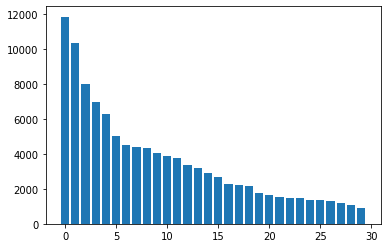

In [351]:
# Check top redditors' prev history stats on AITA
%matplotlib inline
import matplotlib.pyplot as plt

author_all_cnt = Counter()
author_all_cnt.update(df_Comms_AITA_active[df_Comms_AITA_active['author'].isin(most_active_redditors)].author.tolist())
author_all_cnt_sorted = sorted(author_all_cnt.items(), key=lambda x:x[1], reverse=True)

# print(author_all_cnt_sorted)

plt.bar(range(len(author_all_cnt_sorted)), [elem[1] for elem in author_all_cnt_sorted])
plt.show()

In [217]:
# Get AITA submission IDs from the most active redditors

most_active_redditor_submissionIDs = list(set(df_Comms_AITA_active[df_Comms_AITA_active['author'].isin(most_active_redditors)]['id'].tolist()))

"""
Use this list to get reddit post title & selftext using praw API (praw_Submissions_by_submissionID.py)
This is necessary since we will be clustering redditor comments based on the reddit post titles, 
 so that comments are clustered based on the topic of reddit posts
"""

In [307]:
def remove_duplicates_keep_order(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

In [220]:
# Aggregate RoTs

agg_splits = remove_duplicates_keep_order(df_topk_balanced['split'].tolist())
agg_situations = remove_duplicates_keep_order(df_topk_balanced['situation'].tolist())
agg_ids = remove_duplicates_keep_order(df_topk_balanced['id'].tolist())
agg_RoTs = df_topk_balanced.groupby('id', sort=False)['rot'].agg(lambda x:'_____'.join(x)).tolist()
agg_MFs = df_topk_balanced.groupby('id', sort=False)['rot-moral-foundations'].agg(lambda x:'_____'.join(x)).tolist()

assert len(agg_splits) == len(agg_RoTs) == len(agg_MFs)

df_topk_balanced_agg = pd.DataFrame(data={'split': agg_splits, 'situation': agg_situations, 
                        'rot': agg_RoTs, 'id': agg_ids, 'rot-moral-foundations': agg_MFs})

df_topk_balanced_agg.to_csv(os.getcwd()+'/data/social-chem-101/RoT-augmented-topK-balanced-aggregated.tsv', sep='\t', index=False)

In [359]:
# Aggregate Comments

data_dict = {'author':[], 'comment':[], 'id':[]}
df_Comms_AITA_top = df_Comms_AITA_active[df_Comms_AITA_active['author'].isin(most_active_redditors)]

for _author in most_active_redditors:
    minidf = df_Comms_AITA_top[df_Comms_AITA_top['author']==_author]
    
    agg_comments = minidf.groupby('id', sort=False)['body'].agg(lambda x:'_____'.join(x)).tolist()
    agg_ids = remove_duplicates_keep_order(minidf['id'].tolist())
    
    assert len(agg_comments) == len(agg_ids)
    
    data_dict['id'] += agg_ids
    data_dict['comment'] += agg_comments
    data_dict['author'] += [_author]*len(agg_comments)

df_Comms_AITA_top_agg = pd.DataFrame(data=data_dict)
df_Comms_AITA_top_agg.to_csv(os.getcwd()+'/../data/reddit-morality/Comms__(Sub_AITA)__(Redditor_top)__agg.tsv', sep='\t', index=False)

100%|██████████| 30/30 [00:00<00:00, 36.76it/s]


In [366]:
# Match submission IDs and merge the two dataframes

"""
- For all submission IDs found in df_Comms_AITA_top_agg
    - Get its split, situation, RoTs, MFs from df_topk_balanced_agg
    - Identify authors who participated
        - Get their aggregated comments
"""

data_dict = {'split':[], 'situation':[], 'comment':[], 'author':[], 'rot':[], 'rot-moral-foundations':[], 'id':[]}
for _id in tqdm(list(set(df_Comms_AITA_top_agg['id']))):
    
    _df_match_from_topk = df_topk_balanced_agg[df_topk_balanced_agg['id']==_id]
    if len(_df_match_from_topk) == 0:
        continue
        
    _df_match_from_comms = df_Comms_AITA_top_agg[df_Comms_AITA_top_agg['id'] == _id]
    
    data_dict['author'] += _df_match_from_comms['author'].tolist()
    data_dict['comment'] += _df_match_from_comms['comment'].tolist()
    
    num_participated_redditors = len(_df_match_from_comms)
    
    data_dict['split'] += _df_match_from_topk['split'].tolist() * num_participated_redditors
    data_dict['situation'] += _df_match_from_topk['situation'].tolist() * num_participated_redditors
    data_dict['rot'] += _df_match_from_topk['rot'].tolist() * num_participated_redditors
    data_dict['rot-moral-foundations'] += _df_match_from_topk['rot-moral-foundations'].tolist() * num_participated_redditors
    
    data_dict['id'] += [_id] * num_participated_redditors
    
    assert len(data_dict['author']) == len(data_dict['split']) == len(data_dict['id'])

df_topk_Comms = pd.DataFrame(data=data_dict)
df_topk_Comms.sort_values(by=['split', 'id'], ascending=False, inplace=True)
df_topk_Comms.to_csv(os.getcwd()+'/data/reddit-morality/CommsRoTs__(Sub_Sochem)__(Redditor_top)__(Judg_all).tsv', sep='\t', index=False)

100%|██████████| 59919/59919 [03:55<00:00, 254.00it/s]


## Truncate comments

Now we truncate comments based on whether they include proper AITA judgments

In [3]:
AITA_codebook = {'YTA':'YTA', 'NTA':'NTA', 'ESH':'ESH', 'NAH':'NAH', 'INFO':'INFO',
                'YWBTA':'YTA', 'YWNBTA':'NTA'}
AITA_codebook_lower = {'yta':'YTA', 'nta':'NTA', 'esh':'ESH', 'nah':'NAH', 'info':'INFO',
                       'Yta':'YTA', 'Nta':'NTA', 'Esh': 'ESH', 'Nah':'NAH', 'Info':'INFO',
                       'Ywbta':'YTA', 'Ywnbta':'NTA'}
AITA_codebook_expand = {
    "you're the asshole":'YTA', 'you are the asshole':'YTA', 'you are an asshole':'YTA', "you're an asshole":'YTA',
    "you're the a-hole":'YTA', 'you are the a-hole':'YTA', 'you are an a-hole':'YTA', "you're an a-hole":'YTA',
    "you're the ahole":'YTA', 'you are the ahole':'YTA', 'you are an ahole':'YTA', "you're an ahole":'YTA',
    'you would be the asshole':'YTA', "you'd be the asshole":'YTA', 'you would be an asshole':'YTA', "you'd be an asshole":'YTA',
    'you would be the a-hole':'YTA', "you'd be the a-hole":'YTA', 'you would be an a-hole':'YTA', "you'd be an a-hole":'YTA',
    'you would be the ahole':'YTA', "you'd be the ahole":'YTA', 'you would be an ahole':'YTA', "you'd be an ahole":'YTA',
    
    "not the a-hole":'NTA', "not the ahole":'NTA', "not the asshole":'NTA', 
    "not an a-hole":'NTA', "not an ahole":'NTA', "not an asshole":'NTA', 
    "not be the a-hole":'NTA', "not be the ahole":'NTA', "not be the asshole":'NTA', 
    "not an the a-hole":'NTA', "not an the ahole":'NTA', "not an the asshole":'NTA', 
    
    "everyone sucks here":'ESH', 
    
    'no a-holes here':'NAH', 'no aholes here':'NAH', 'no assholes here':'NAH',
    
    'not enough info': 'INFO'
}
    
            
    
def code_match(codebook, text, votes, match):
    answer = ''
    for _code in codebook.keys():
        if _code in text:
            votes[codebook[_code]] += 1
            match = True
            answer = codebook[_code]

    return votes, match, answer

In [9]:
def add_judgment_remove_commsWithoutJudgment(_df):
    subID_author_to_votes = {}
    matching_indices, redditor_answers = [], []

    for idx, row in _df.iterrows():
        _subID_author = row['id'] + '___###___' + row['author']
        if _subID_author in subID_author_to_votes:
            match = False

            subID_author_to_votes[_subID_author], match, answer = code_match(AITA_codebook, 
                                                row['comment'], subID_author_to_votes[_subID_author], match)
            if not match:
                subID_author_to_votes[_subID_author], match, answer = code_match(AITA_codebook_lower, 
                                                row['comment'], subID_author_to_votes[_subID_author], match)
            if not match:
                subID_author_to_votes[_subID_author], match, answer = code_match(AITA_codebook_expand, 
                                                row['comment'].lower(), subID_author_to_votes[_subID_author], match)

        else:
            subID_author_to_votes[_subID_author] = {'YTA':0, 'NTA':0, 'ESH':0, 'NAH':0, 'INFO':0}
            match = False

            subID_author_to_votes[_subID_author], match, answer = code_match(AITA_codebook, 
                                                row['comment'], subID_author_to_votes[_subID_author], match)
            if not match:
                subID_author_to_votes[_subID_author], match, answer = code_match(AITA_codebook_lower, 
                                                row['comment'], subID_author_to_votes[_subID_author], match)
            if not match:
                subID_author_to_votes[_subID_author], match, answer = code_match(AITA_codebook_expand, 
                                                row['comment'].lower(), subID_author_to_votes[_subID_author], match)

        redditor_answers.append(answer)
        if match:
            matching_indices.append(idx)
    
    _df['judgment'] = redditor_answers
    return _df[_df.index.isin(matching_indices)], subID_author_to_votes

In [16]:
df_Comms_AITA_top_agg_judge, subID_author_to_votes = add_judgment_remove_commsWithoutJudgment(df_Comms_AITA_top_agg)

print('original instances: %d, situations: %d, authors: %d'%(len(df_Comms_AITA_top_agg), len(list(set(df_Comms_AITA_top_agg['id'].tolist()))), len(list(set(df_Comms_AITA_top_agg['author'].tolist())))))
print('matching instances: %d, situations: %d, authors: %d'%(len(df_Comms_AITA_top_agg_judge), len(list(set(df_Comms_AITA_top_agg_judge['id'].tolist()))), len(list(set(df_Comms_AITA_top_agg_judge['author'].tolist())))))

original instances: 78525, situations: 59919, authors: 30
matching instances: 69775, situations: 54661, authors: 30


In [384]:
df_topk_Comms_match, subID_author_to_votes = add_judgment_remove_commsWithoutJudgment(df_topk_Comms)

print('original instances: %d, situations: %d, authors: %d'%(len(df_topk_Comms), len(list(set(df_topk_Comms['id'].tolist()))), len(list(set(df_topk_Comms['author'].tolist())))))
print('matching instances: %d, situations: %d, authors: %d'%(len(matching_indices), len(list(set(df_topk_Comms_match['id'].tolist()))), len(list(set(df_topk_Comms_match['author'].tolist())))))

original instances: 16394, situations: 10518, authors: 30
matching instances: 14820, situations: 9929, authors: 30


In [17]:
# Add a binary 'label' column

judgment_mapping = {'NAH':0, 'NTA':0, 'YTA':1, 'ESH':1, 'INFO':-1, '':-1}
df_Comms_AITA_top_agg_judge['label'] = df_Comms_AITA_top_agg_judge['judgment'].map(lambda x:judgment_mapping[x])
df_topk_Comms_match['label'] = df_topk_Comms_match['judgment'].map(lambda x:judgment_mapping[x])

/Users/yh/opt/anaconda3/envs/dev37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [14]:
# Add controversiality for future analysis
def add_controv(_df, subID_author_to_votes):
    subID_author_to_votesCntrov = {}

    for key in subID_author_to_votes:
        yes = subID_author_to_votes[key]['YTA'] + subID_author_to_votes[key]['ESH']
        no = subID_author_to_votes[key]['NTA'] + subID_author_to_votes[key]['NAH']
        try:
            majority_percent = round(yes/(yes+no) if yes>no else no/(yes+no), 2)
        except:
            continue

        subID_author_to_votesCntrov[key] = majority_percent

    for _id, _author in zip(_df['id'].tolist(), _df['author'].tolist()):
        key = _id+'___###___'+_author
        if key not in subID_author_to_votesCntrov:
            subID_author_to_votesCntrov[key] = -1

    _df['controv'] = _df.apply(lambda x:subID_author_to_votesCntrov[x['id']+'___###___'+x['author']], axis=1)
    return _df

In [413]:
df_topk_Comms_match = add_controv(df_topk_Comms_match, subID_author_to_votes)
df_topk_Comms_match.to_csv(os.getcwd()+'/data/reddit-morality/CommsRoTs__(Sub_Sochem)__(Redditor_top)__(Judge_trunc).tsv', sep='\t', index=False)

In [18]:
df_Comms_AITA_top_agg_judge = add_controv(df_Comms_AITA_top_agg_judge, subID_author_to_votes)
df_Comms_AITA_top_agg_judge.to_csv(os.getcwd()+'/data/reddit-morality/Comms__(Sub_AITA)__(Redditor_top)__agg__(Judge_trunc).tsv', sep='\t', index=False)

/Users/yh/opt/anaconda3/envs/dev37/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
